# AIM0405D2203 Lab 1 Word Embedding & Deep Learning for NLP
---
Karena kita akan melakukan pemodelan untuk tugas klasifikasi teks dengan Deep Learning, maka setting runtime type ke GPU (Google Colab).

`Runtime --> Change runtime type --> Hardware accelerator: Pilih GPU --> Save`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 01 Install & Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 02 Data Acquisition
Penjelasan Label 
* 0: SMS normal 
* 1: SMS fraud atau penipuan 
* 2: SMS promo

In [ ]:
# Download dataset
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv

--2022-08-24 07:41:41--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128896 (126K) [text/plain]
Saving to: ‚Äòdataset_sms_spam_v1.csv.1‚Äô

dataset_sms_spam_v1 100%[===================>] 125.88K  --.-KB/s    in 0.02s   

2022-08-24 07:41:41 (5.30 MB/s) - ‚Äòdataset_sms_spam_v1.csv.1‚Äô saved [128896/128896]



In [102]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/dataset_sms_spam_v1.csv')
data.head()

teks  label
0  [PROMO] Beli paket Flash mulai 1GB di MY TELKO...      2
1  2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...      2
2  2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...      2
3  2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...      2
4  4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...      2

# 03 Text Preprocessing

In [103]:
'''
Disini, kita tidak banyak melakukan preprocessing karena kita tidak ingin mengubah makna (konteks) dari suatu kata yang menyusun suatu kalimat
'''
import re

def text_preprocessing(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [104]:
%time data['clean_teks'] = data['teks'].apply(text_preprocessing)

# Perhatikan waktu komputasi ketika proses text preprocessing, bandingkan dengan langkah text preprocessing pada pertemuan sebelumnya

CPU times: user 16.4 ms, sys: 0 ns, total: 16.4 ms
Wall time: 16.7 ms


In [105]:
data.head()

teks  label  \
0  [PROMO] Beli paket Flash mulai 1GB di MY TELKO...      2   
1  2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...      2   
2  2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...      2   
3  2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...      2   
4  4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...      2   

                                          clean_teks  
0  promo beli paket flash mulai gb di my telkomse...  
1  gb hari hanya rp  ribu spesial buat anda yang ...  
2  plg yth sisa kuota flash anda kb download myte...  
3  plg yth sisa kuota flash anda kb download myte...  
4  gb hari hanya rp  ribu spesial buat anda yang ...

# 05 Word Embedding

## Word2Vec from Scratch

In [106]:
# Import library
import gensim

# Lihat versi Gensim yang digunakan
gensim.__version__

'3.6.0'

In [107]:
# Tokenize kata pada setiap kalimat
def tokenization(text):
  text = re.split('\W+', text)
  return text

sentences = data['clean_teks'].apply(lambda x: tokenization(x.lower()))
sentences

0       [promo, beli, paket, flash, mulai, gb, di, my,...
1       [gb, hari, hanya, rp, ribu, spesial, buat, and...
2       [plg, yth, sisa, kuota, flash, anda, kb, downl...
3       [plg, yth, sisa, kuota, flash, anda, kb, downl...
4       [gb, hari, hanya, rp, ribu, spesial, buat, and...
                              ...                        
1138    [yooo, sama, oke, nanti, aku, umumin, di, grup...
1139    [sebelumnya, ga, ad, nulis, kerudung, kirain, ...
1140                                [mba, mau, kirim, ya]
1141    [nama, beaok, bwrangkat, pagimau, cas, atay, t...
1142                    [no, bri, atas, nama, kamu, mana]
Name: clean_teks, Length: 1143, dtype: object

In [108]:
# Defenisikan parameter training Word2Vec

EMBEDDING_SIZE = 100    # Dimensi word vektor / neuron pada projection (hidden) layer
WINDOW_SIZE = 5         # Window size. Jarak maksimum antara kata saat ini dan yang diprediksi dalam sebuah
MIN_WORD  = 1           # Model akan mengabaikan semua kata dengan frekuensi total lebih rendah dari ini (opsional)
EPOCH = 100             # Jumlah iterasi (epoch).
SG = 1                  # Strategi algoritma pelatihan: 1 untuk skip-gram, 0 untuk CBOW
NEGATIVE = 5            # Negative sampling. Jika 0, negative sampling tidak digunakan

In [109]:
%%time 

# Proses training Word2Vec
from gensim.models import Word2Vec, FastText, KeyedVectors

model_word2vec = Word2Vec(sentences, size=EMBEDDING_SIZE, sg=SG, min_count=MIN_WORD, window=WINDOW_SIZE, negative=NEGATIVE, iter=EPOCH)

CPU times: user 10.8 s, sys: 60.2 ms, total: 10.8 s
Wall time: 6.52 s


In [11]:
# Save Word2Vec sebagai full model
model_word2vec.save('myvec-word2vec-100.model')

In [12]:
# Save Word2Vec sebagai wordvectors. Hanya menyimpan kata & trained embeddingnya
word2vec_word_vectors = model_word2vec.wv
word2vec_word_vectors.save('myvec-word2vec-100.wordvectors')

In [110]:
# Cari nilai vektor dari kata tertentu
model_word2vec.wv['hadiah']

array([-0.03881319,  0.63477117,  0.24771848, -0.50398225,  0.762612  ,
        0.7335767 ,  0.91149086,  0.38632458,  0.6968513 ,  0.92883575,
       -0.83573145,  0.29479077, -0.41622517,  0.20235583,  0.1551254 ,
       -0.47272435, -0.89029145, -0.65892273, -0.15853621,  0.74872947,
        0.06010745,  0.8214955 ,  0.13145205,  0.3046647 ,  0.3617658 ,
        0.0049615 ,  0.15116443, -0.48690587, -0.4735797 ,  0.34290543,
        0.6805905 ,  0.81770504,  0.20754655,  1.0937434 , -0.20933576,
       -0.17553566, -0.8907709 ,  0.4012046 , -0.18297854,  0.22777323,
       -0.01583087, -0.21743163,  1.0474151 ,  0.0820907 , -0.18174994,
       -0.51027554, -0.24372573, -0.4968575 , -0.11891746,  0.7224788 ,
       -0.6209966 ,  0.7568825 ,  0.03504959,  0.218832  , -0.3582384 ,
        0.09162428, -0.23702073,  0.14720426, -0.03727952,  0.39579868,
       -0.5369031 , -0.11684513, -0.48023084,  0.6084518 , -0.22745939,
        0.8450804 ,  0.09108897, -0.43356827, -0.21856438, -0.55

In [14]:
# Menemukan kata kata teratas yang paling mirip dari kata terentu
# Menghitung kesamaan dari vektor bobot proyeksi dari kata-kata yang diberikan dan vektor untuk setiap kata dalam model.

model_word2vec.wv.most_similar('hadiah')

[('mendpt', 0.6889728307723999),
 ('unt', 0.6539772748947144),
 ('mndpt', 0.644702672958374),
 ('toyota', 0.6434768438339233),
 ('andaxvf', 0.6386038064956665),
 ('andadidinfo', 0.638436496257782),
 ('nosim', 0.636125922203064),
 ('slmt', 0.6360843181610107),
 ('jaguar', 0.6355172395706177),
 ('yarispin', 0.6318314075469971)]

In [15]:
# Kata-kata yang ingin kita plot vektornya
word_list = ['hadiah', 'promosi', 'sms', 'malam', 'makan', 'telkomsel', 'selamat', 'juta', 'nama', 'duit', 'uang']

# daftar vektor dari kata-kata tersebut
word_vectors = np.array([model_word2vec.wv[w] for w in word_list])
print(word_vectors)

[[-0.04905234  0.6202141   0.19921347 ... -0.71524984  0.57001805
   0.42735308]
 [ 0.57990557  0.29203284 -0.25906333 ...  0.3380542  -0.24018869
   0.45910344]
 [ 0.22104123 -0.11845204  0.5567357  ...  0.00433124  0.6243761
   1.1464564 ]
 ...
 [-1.2395549   0.5058381   0.40325123 ...  0.14675367  0.51418227
   0.5336583 ]
 [ 0.04122879  0.37046522 -0.04015472 ... -0.30812407  0.3158491
  -0.20644909]
 [ 0.45034105  0.6696929  -0.47995785 ... -0.12043848 -0.61974597
   0.50177485]]


In [16]:
# Reduksi dimensi vektor ke 2D menggunakan PCA
from sklearn.decomposition import PCA, KernelPCA

dimred = PCA(n_components=2, copy=False, whiten=True)
red_word_vectors = dimred.fit_transform(word_vectors)

In [17]:
# Lihat vektor hasil PCA (dari 5 dimensi menjadi 2 dimensi)
red_word_vectors

array([[-0.14419205, -0.6917715 ],
       [ 0.01975165,  0.49154907],
       [-0.43722978,  2.2108915 ],
       [-0.24376765, -0.1451236 ],
       [ 1.1417792 ,  0.8892639 ],
       [-1.1894212 , -1.1417668 ],
       [-0.6832528 , -0.5551284 ],
       [-0.61677784, -0.44149768],
       [ 2.2369876 , -1.1880821 ],
       [ 0.7179838 ,  0.6007001 ],
       [-0.801861  , -0.02903499]], dtype=float32)

In [18]:
def plot(datas, labels, fc='yellow'):
  # plot the dots
  plt.subplots_adjust(bottom = 0.1)
  plt.scatter(datas[:, 0], datas[:, 1], marker='o')

  # annotate labels
  for label, x, y in zip(labels, datas[:, 0], datas[:, 1]):
    plt.annotate(label, \
                 xy=(x, y), xytext=(-15, 15), \
                 textcoords='offset points', ha='right', va='bottom', \
                 bbox=dict(boxstyle='round,pad=0.3', fc=fc, alpha=0.5), \
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
  plt.show()

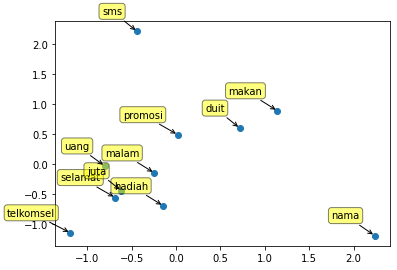

In [19]:
plot(red_word_vectors, word_list)

In [20]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 88 kB 6.5 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.1 MB 60.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=7b4201e71e3544ec3cb6fb1c082f33cb3a513ca8184fcc6fd281daced827b63a
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=d2908229a67ec50275126bd20efae2f0f224c2f80e4711a988b7fb06ccdec85e
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [21]:
from umap import UMAP
import plotly.express as px

In [22]:
model_word2vec.wv.vectors

array([[ 0.26543128, -0.36896998,  0.38538474, ...,  0.3343802 ,
         0.23724239, -0.05051817],
       [ 0.5975126 , -0.2919124 ,  0.39804015, ...,  0.19439259,
         0.5728808 ,  0.3046356 ],
       [ 0.5237593 ,  1.0810063 ,  0.7972945 , ..., -0.92792207,
         0.36112377, -0.11025457],
       ...,
       [-0.305398  ,  0.2683681 , -0.23486517, ...,  0.1347665 ,
        -0.04785378,  0.10733873],
       [-0.3147454 ,  0.2645368 , -0.19865268, ...,  0.13727158,
        -0.07784006,  0.08772784],
       [-0.24714303,  0.20819837, -0.21490906, ...,  0.10499126,
        -0.06012364,  0.10241362]], dtype=float32)

In [23]:
mod = model_word2vec.wv

In [31]:
X = UMAP().fit_transform(mod.vectors)
df = pd.DataFrame(X, columns=['umap1', 'umap2'])
df['text'] = mod.index2word
fig = px.scatter(df, x='umap1', y='umap2', text='text')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=800,
    title_text='Reduce FastText Visualization'
)
fig.show()

## FastText (Pre-Trained Model)
Pada contoh Word2Vec diatas, kita melatih suatu shallow neural network pada dataset SMS spam untuk mendapatkan word vectors. Pada contoh FastText ini, kita akan memanfaatkan pre-trained word vector yang sudah dilatih pada kumpulan data yang besar.

In [ ]:
!pip -q install fasttext

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 68 kB 3.0 MB/s 


In [24]:
import nltk
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
nltk.download('punkt')
from gensim.models import FastText

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Download dan unzip dataset
# Warning: proses download lama dan memakan diskspace yang besar (sekitar 7GB)
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz

--2022-08-24 07:53:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‚Äòcc.en.300.bin.gz‚Äô

cc.en.300.bin.gz    100%[===================>]   4.19G  64.7MB/s    in 67s     

2022-08-24 07:54:59 (63.8 MB/s) - ‚Äòcc.en.300.bin.gz‚Äô saved [4503593528/4503593528]



In [38]:
import fasttext

# Load model FastText
# ft_model = fasttext.load_model("cc.en.300.bin")

ModuleNotFoundError: ignored

In [25]:
data

teks  label  \
0     [PROMO] Beli paket Flash mulai 1GB di MY TELKO...      2   
1     2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...      2   
2     2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...      2   
3     2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...      2   
4     4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...      2   
...                                                 ...    ...   
1138     Yooo sama2, oke nanti aku umumin di grup kelas      0   
1139  üòÅ sebelumnya ga ad nulis kerudung. Kirain warn...      0   
1140                               Mba mau kirim 300 ya      0   
1141  nama1  beaok bwrangkat pagi...mau cas atay tra...      0   
1142                         No bri atas nama kamu mana      0   

                                             clean_teks  
0     promo beli paket flash mulai gb di my telkomse...  
1     gb hari hanya rp  ribu spesial buat anda yang ...  
2     plg yth sisa kuota flash anda kb download myte...  
3     plg yth sisa kuota flash anda kb download myte...  
4     gb hari hanya rp  ribu spesial buat anda yang ...  
...                                                 ...  
1138       yooo sama oke nanti aku umumin di grup kelas  
1139  sebelumnya ga ad nulis kerudung kirain warna jins  
1140                                  mba mau kirim  ya  
1141     nama  beaok bwrangkat pagimau cas atay tranfer  
1142                         no bri atas nama kamu mana  

[1143 rows x 3 columns]

In [26]:
sentences = [word_tokenize(review.lower()) for review in tqdm(data.clean_teks)]
sentences

  0%|          | 0/1143 [00:00<?, ?it/s]

[['promo',
  'beli',
  'paket',
  'flash',
  'mulai',
  'gb',
  'di',
  'my',
  'telkomsel',
  'app',
  'dpt',
  'extra',
  'kuota',
  'gb',
  'g',
  'lte',
  'dan',
  'extra',
  'nelpon',
  'hingga',
  'mnthr',
  'buruan',
  'cek',
  'di',
  'tselmemytsel',
  'sk'],
 ['gb',
  'hari',
  'hanya',
  'rp',
  'ribu',
  'spesial',
  'buat',
  'anda',
  'yang',
  'terpilih',
  'aktifkan',
  'sekarang',
  'juga',
  'di',
  'promo',
  'sd',
  'nov',
  'buruan',
  'aktifkan',
  'sekarang',
  'sk'],
 ['plg',
  'yth',
  'sisa',
  'kuota',
  'flash',
  'anda',
  'kb',
  'download',
  'mytelkomsel',
  'apps',
  'di',
  'utk',
  'cek',
  'kuotabeli',
  'paket',
  'flash',
  'atau',
  'hub'],
 ['plg',
  'yth',
  'sisa',
  'kuota',
  'flash',
  'anda',
  'kb',
  'download',
  'mytelkomsel',
  'apps',
  'di',
  'utk',
  'cek',
  'kuotabeli',
  'paket',
  'flash',
  'atau',
  'hub'],
 ['gb',
  'hari',
  'hanya',
  'rp',
  'ribu',
  'spesial',
  'buat',
  'anda',
  'yang',
  'terpilih',
  'aktifkan',
  '

In [27]:
model = FastText(sentences=sentences, size=128, window=5, min_count=3, workers=4, iter=1000, sg=1, hs=0)

In [28]:
model.save('data.fasttext')

In [45]:
ft = model.wv

In [46]:
X = UMAP().fit_transform(ft.vectors)
df = pd.DataFrame(X, columns=['umap1', 'umap2'])
df['text'] = ft.index2word
fig = px.scatter(df, x='umap1', y='umap2', text='text')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=800,
    title_text='Reduce FastText Visualization'
)
fig.show()

In [ ]:
# Lihat vektor kata tertentu menggunakan pre-trained FastText
print(ft_model['hadiah'])

[ 2.31886618e-02 -9.02718380e-02 -3.26942317e-02  4.43942025e-02
  1.16834603e-01  1.29350051e-01 -1.75389405e-02  1.32096335e-01
 -1.11069754e-01  9.42594651e-03 -1.92331269e-01  4.87022214e-02
 -5.89958690e-02 -2.72452720e-02  2.42144074e-02  2.68125534e-03
 -6.44036084e-02  8.76408350e-03 -7.87095428e-02  5.56880720e-02
 -5.49955964e-02 -2.05840413e-02  2.97657382e-02 -1.48930848e-02
  5.00083379e-02  5.20066731e-02  5.92291020e-02  9.67174694e-02
  1.05014993e-02  2.70687371e-01  2.61476841e-02 -9.76984128e-02
 -3.81510258e-02 -5.54437637e-02  1.40345320e-02  5.98153472e-02
  2.05978937e-02  6.20838888e-02 -4.92071509e-02  4.86903377e-02
 -8.15637633e-02  9.45009813e-02  4.54714634e-02  2.62403525e-02
 -3.23774070e-02  3.31735723e-02 -2.53115129e-02  3.84174590e-03
 -2.66067982e-02 -3.60902213e-02  2.70026959e-02 -3.82749140e-02
 -1.75837670e-02  8.24360400e-02 -1.41439915e-01 -6.02689497e-02
 -1.00951986e-02  2.63172835e-02  3.92115526e-02  3.08932569e-02
  5.78716993e-02 -1.84465

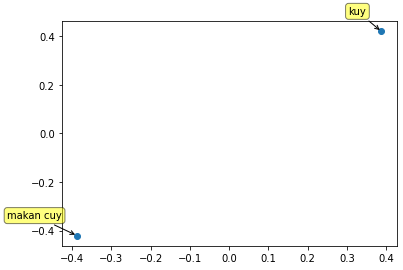

In [97]:
list_kalimat = ['makan cuy', 'kuy'] 
word_vectors_fasttext = np.array([ft[w] for w in list_kalimat])
pca = PCA(n_components=2, copy=False, whiten=True) # Proses reduksi dimensi

fasttext_word_vectors = pca.fit_transform(word_vectors_fasttext)

plot(word_vectors_fasttext, list_kalimat)

# 06 Deep Learning for NLP

## Long short term memory network (LSTM)

### Memilih Panjang Sequence (max_length)

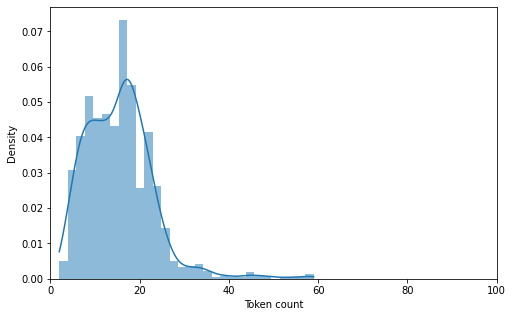

In [111]:
'''
Ada banyak cara untuk menentukan max_length
Intuisinya adalah kita tidak ingin memotong kalimat, atau terlalu banyak menambahkan padding (komputasi lebih lama)
Contoh ini, max_lenght ditentukan dari distribusi token pada dataset 
'''
token_lens = []

for text in data['clean_teks']:
    tokens = text.split()
    token_lens.append(len(tokens))

plt.figure(figsize=(8, 5))
sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [112]:
MAX_SEQ_LENGTH = 60

### Preparing Data for Embedding Layer

#### Tokenizing Data
Proses ini berbeda dengan tokenization pada text-preprocessing. Pada pemodelan dengan deep learning, tokenization merujuk pada membuat dictionary berdasarkan dataset.

In [113]:
'''
Proses vektorisasi teks dengan mengubah setiap teks menjadi token urutan bilangan int (setiap bilangan int menjadi indeks token dalam dictionary) 
'''
from keras.preprocessing.text import Tokenizer

In [114]:
NUM_WORDS = 100       # Frekuensi kemunculan kata. Hanya num_words-1 yang akan disimpan pada dictionary. Berarti kata dengan kemunculan <=num_words tidak digunakan.
OOV_TOKEN = '<unk>'   # Token khusus untuk mengganti kata yang tidak terdaftar dalam dictionary.

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN, lower=True, split=' ')
tokenizer.fit_on_texts(data['clean_teks'])

# Tambahkan token padding untuk menyamakan ukuran dimensi embedding layer
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

WV_DICTIONARY = tokenizer.word_index

WV_DICTIONARY_SIZE = len(WV_DICTIONARY)
print(WV_DICTIONARY_SIZE) # Lihat kata unik pada dictionary yang dihasilkan

4287


In [115]:
# Lihat dictionary hasil tokenisasi
WV_DICTIONARY

{'<unk>': 1,
 'di': 2,
 'anda': 3,
 'ke': 4,
 'ini': 5,
 'info': 6,
 'ada': 7,
 'yg': 8,
 'aku': 9,
 'mau': 10,
 'dan': 11,
 'hadiah': 12,
 'dari': 13,
 'pin': 14,
 'no': 15,
 'sms': 16,
 'klik': 17,
 'cek': 18,
 'rp': 19,
 'nama': 20,
 'aja': 21,
 'pulsa': 22,
 'paket': 23,
 'hub': 24,
 'saya': 25,
 'yang': 26,
 'ya': 27,
 'untuk': 28,
 'hari': 29,
 'promo': 30,
 'jt': 31,
 'resmi': 32,
 'atau': 33,
 'rb': 34,
 'gb': 35,
 'pemenang': 36,
 'bisa': 37,
 'selamat': 38,
 'isi': 39,
 'kalau': 40,
 'utk': 41,
 'dr': 42,
 'jam': 43,
 'dengan': 44,
 'uinfo': 45,
 'nya': 46,
 'kamu': 47,
 'tri': 48,
 'ga': 49,
 'kuota': 50,
 'gratis': 51,
 'sd': 52,
 'ketik': 53,
 'ulang': 54,
 'care': 55,
 'bonus': 56,
 'hanya': 57,
 'sudah': 58,
 'pak': 59,
 'beli': 60,
 'berlaku': 61,
 'maaf': 62,
 'dgn': 63,
 'indosat': 64,
 'juga': 65,
 'bb': 66,
 'kita': 67,
 'itu': 68,
 'kalo': 69,
 'sama': 70,
 'nanti': 71,
 'kirim': 72,
 'mobil': 73,
 'telah': 74,
 'kasih': 75,
 'yth': 76,
 'kami': 77,
 'sekarang': 78

#### Text to Sequence

In [116]:
# Proses mengubah token hasil tokenisasi menjadi urutan bilangan int berdasarkan index dictionary.
data_seq = tokenizer.texts_to_sequences(data['clean_teks'])

In [117]:
# Lihat hasil setelah di ubah menjadi sequences
print(data['clean_teks'][10])
print(data_seq[10])

anda akan berhenti berlangganan paket flash ketik flashspasiya jika setuju tunggu sms konfirmasi penonaktifan paket anda
[3, 1, 1, 1, 23, 96, 53, 1, 1, 1, 1, 16, 1, 1, 23, 3]


#### Add Padding & Truncation

In [118]:
'''
Proses mengubah data dari sequence menjadi array bentuk 2D Numpy (num_samples, num_timesteps). 
num_timesteps adalah argumen maxlen jika disediakan, atau panjang dari sequence terpanjang dalam daftar.

Sequence yang lebih pendek dari num_timesteps diisi dengan nilai hingga panjangnya sama dengan num_timesteps (padding).
Sequence yang lebih panjang dari num_timesteps dipotong sehingga sesuai dengan panjang yang diinginkan (truncate).
'''

from keras.preprocessing.sequence import pad_sequences

In [119]:
PADDING = 'post'        # Berikan padding untuk setiap sequences. Terdapat dua pilihan dalam melakukan padding 'pre' or 'post'.
TRUNCATING = 'post'     # Menghapus token dari sequences yang lebih besar dari max_lenght. Terdapat dua pilihan dalam melakukan truncanting 'pre' or 'post'.

data_pad = pad_sequences(data_seq, maxlen=MAX_SEQ_LENGTH, padding=PADDING, truncating=TRUNCATING)

In [120]:
print(data['clean_teks'][10])
print(data_seq[10])
print(data_pad[10])

anda akan berhenti berlangganan paket flash ketik flashspasiya jika setuju tunggu sms konfirmasi penonaktifan paket anda
[3, 1, 1, 1, 23, 96, 53, 1, 1, 1, 1, 16, 1, 1, 23, 3]
[ 3  1  1  1 23 96 53  1  1  1  1 16  1  1 23  3  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


### One-hot Encoding

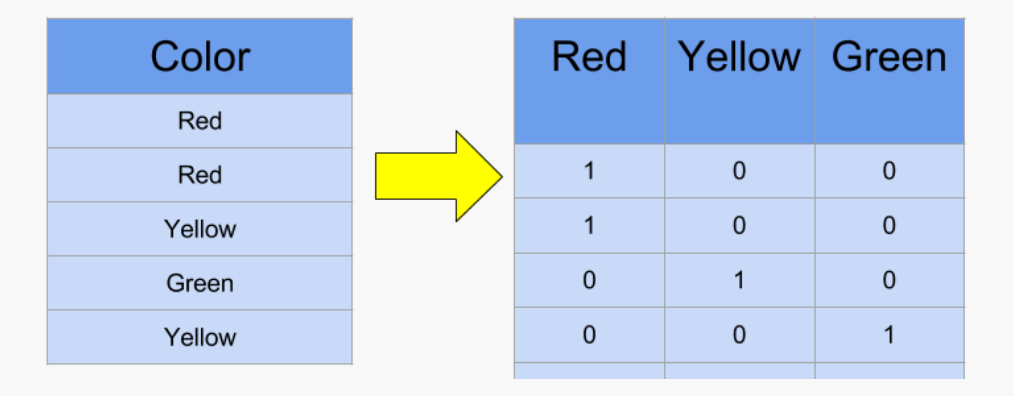

In [121]:
from tensorflow.keras.utils import to_categorical

Y = to_categorical(data['label'], num_classes=len(data['label'].unique()))  # Lakukan one-hot encoding pada label (y)

In [122]:
Y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

### Train & Test Data Splitting

In [123]:
# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(data_pad, Y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((914, 60), (229, 60), (914, 3), (229, 3))

### Define Model Architecture (LSTM)



In [124]:
'''
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

model_LSTM = Sequential()
model_LSTM.add(Embedding(                                           # Buat embedding layer yang menerima panjang dictionary hasil Tokenisasi
    input_dim = WV_DICTIONARY_SIZE,
    input_length = MAX_SEQ_LENGTH,
    output_dim = 64))      
model_LSTM.add(LSTM(64))                                            # Tambahkan satu layer LSTM
model_LSTM.add(Dropout(0.5))                  
model_LSTM.add(Dense(3, activation='softmax'))

In [125]:
model_LSTM.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 60, 64)            274368    
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 307,587
Trainable params: 307,587
Non-trainable params: 0
_________________________________________________________________


In [126]:
# Compile model
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [127]:
%%time

EPOCH = 15
BATCH_SIZE = 32

history_LSTM = model_LSTM.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/15
29/29 [==============================] - 2s 23ms/step - loss: 1.0592 - accuracy: 0.4869 - val_loss: 1.0247 - val_accuracy: 0.5371
Epoch 2/15
29/29 [==============================] - 0s 8ms/step - loss: 1.0460 - accuracy: 0.4880 - val_loss: 1.0086 - val_accuracy: 0.5371
Epoch 3/15
29/29 [==============================] - 0s 9ms/step - loss: 1.0473 - accuracy: 0.4880 - val_loss: 1.0206 - val_accuracy: 0.5415
Epoch 4/15
29/29 [==============================] - 0s 9ms/step - loss: 0.9470 - accuracy: 0.5580 - val_loss: 0.9325 - val_accuracy: 0.5502
Epoch 5/15
29/29 [==============================] - 0s 9ms/step - loss: 0.7670 - accuracy: 0.6050 - val_loss: 0.7525 - val_accuracy: 0.5939
Epoch 6/15
29/29 [==============================] - 0s 7ms/step - loss: 0.8537 - accuracy: 0.5481 - val_loss: 0.7538 - val_accuracy: 0.5852
Epoch 7/15
29/29 [==============================] - 0s 7ms/step - loss: 0.9060 - accuracy: 0.6433 - val_loss: 0.7418 - val_accuracy: 0.7162
Epoch 8/15
29/29 [=

In [128]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

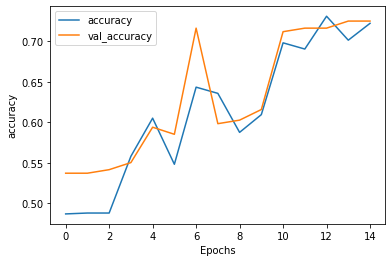

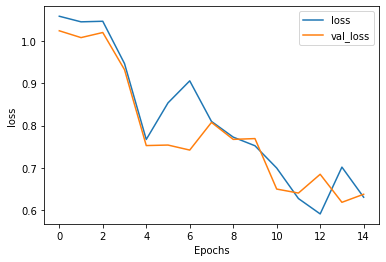

In [129]:
plot_graphs(history_LSTM, 'accuracy')
plot_graphs(history_LSTM, 'loss')

In [130]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCH):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history_LSTM.history['accuracy'][i], history_LSTM.history['loss'][i], history_LSTM.history['val_accuracy'][i], history_LSTM.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.486871 	   1.059227 	   0.537118 	   1.024737
       2   0.487965 	   1.045971 	   0.537118 	   1.008574
       3   0.487965 	   1.047307 	   0.541485 	   1.020643
       4   0.557987 	   0.946966 	   0.550218 	   0.932509
       5   0.605033 	   0.766995 	   0.593886 	   0.752529
       6   0.548140 	   0.853745 	   0.585153 	   0.753758
       7   0.643326 	   0.906012 	   0.716157 	   0.741837
       8   0.635667 	   0.809775 	   0.598253 	   0.807460
       9   0.587527 	   0.772556 	   0.602620 	   0.767201
      10   0.609409 	   0.752107 	   0.615721 	   0.769092
      11   0.698031 	   0.699250 	   0.711790 	   0.649372
      12   0.690372 	   0.626877 	   0.716157 	   0.639884
      13   0.730853 	   0.590440 	   0.716157 	   0.684448
      14   0.701313 	   0.701441 	   0.724891 	   0.617961
      15   0.722101 	   0.630008 	   0.724891 	   0.637099


In [172]:
y_pred = np.argmax(model_LSTM.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy = model_LSTM.evaluate(X_test, y_test)
print(classification_report(y_pred, y_true))

8/8 [==============================] - 0s 5ms/step - loss: 0.6371 - accuracy: 0.7249
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       114
           1       0.95      0.50      0.66       115
           2       0.00      0.00      0.00         0

    accuracy                           0.72       229
   macro avg       0.61      0.48      0.52       229
weighted avg       0.91      0.72      0.78       229



### Evaluate

# New Section

In [131]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model_LSTM.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy = model_LSTM.evaluate(X_test, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.7249


In [132]:
from sklearn.metrics import classification_report

# Tampilkan laporan klasifikasi yang dilakukan model pada data uji
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       114
           1       0.95      0.50      0.66       115
           2       0.00      0.00      0.00         0

    accuracy                           0.72       229
   macro avg       0.61      0.48      0.52       229
weighted avg       0.91      0.72      0.78       229



# RNN + Word2Vec

In [194]:
# Load word2vec yang telah kita simpan
from gensim.models import KeyedVectors

my_word2vec = KeyedVectors.load('myvec-word2vec-100.wordvectors', mmap='r')
my_word2vec_vocab = my_word2vec.wv.vocab     

VOCAB_SIZE = len(my_word2vec_vocab)
EMBEDDING_SIZE = my_word2vec.vector_size

print(VOCAB_SIZE)
print(EMBEDDING_SIZE)

4289
100


In [193]:
EMBEDDING_MATRIX = np.zeros(shape=(WV_DICTIONARY_SIZE, EMBEDDING_SIZE))

for word, i in tokenizer.word_index.items():
  embed_vector = word2vec_dict.get(word)
  if embed_vector is not None:               # Word is in the vocabulary learned by the w2v model
    EMBEDDING_MATRIX[i] = embed_vector

In [188]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, SimpleRNN
from tensorflow.keras.initializers import Constant

RNN_w2v = Sequential()

RNN_w2v.add(Embedding(
   input_dim = WV_DICTIONARY_SIZE,
    output_dim = EMBEDDING_SIZE,
    input_length = MAX_SEQ_LENGTH,
    trainable = False,
    embeddings_initializer = Constant(EMBEDDING_MATRIX))
)

RNN_w2v.add(SimpleRNN(128))
# RNN_w2v.add(Dropout(0.5))  
RNN_w2v.add(Dense(3, activation='softmax'))

RNN_w2v.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 60, 100)           428700    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense_12 (Dense)            (None, 3)                 387       
                                                                 
Total params: 458,399
Trainable params: 29,699
Non-trainable params: 428,700
_________________________________________________________________


In [195]:
RNN_w2v.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [196]:
%%time
EPOCH = 15
BATCH_SIZE = 32

history_RNN_w2v =RNN_w2v.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/15
29/29 [==============================] - 2s 55ms/step - loss: 1.0669 - accuracy: 0.4683 - val_loss: 1.0191 - val_accuracy: 0.5371
Epoch 2/15
29/29 [==============================] - 1s 48ms/step - loss: 1.0442 - accuracy: 0.4792 - val_loss: 1.0108 - val_accuracy: 0.5371
Epoch 3/15
29/29 [==============================] - 2s 84ms/step - loss: 1.0464 - accuracy: 0.5088 - val_loss: 1.0009 - val_accuracy: 0.5677
Epoch 4/15
29/29 [==============================] - 2s 72ms/step - loss: 0.8986 - accuracy: 0.6346 - val_loss: 0.9104 - val_accuracy: 0.6507
Epoch 5/15
29/29 [==============================] - 1s 45ms/step - loss: 0.8974 - accuracy: 0.6499 - val_loss: 1.0992 - val_accuracy: 0.5764
Epoch 6/15
29/29 [==============================] - 1s 44ms/step - loss: 0.9309 - accuracy: 0.6411 - val_loss: 1.0174 - val_accuracy: 0.5983
Epoch 7/15
29/29 [==============================] - 1s 45ms/step - loss: 0.9086 - accuracy: 0.6422 - val_loss: 0.9313 - val_accuracy: 0.6201
Epoch 8/15
29

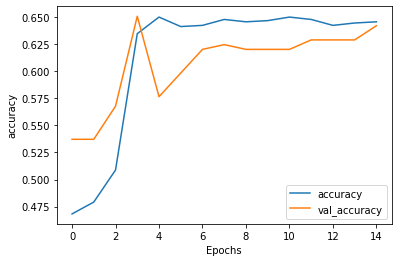

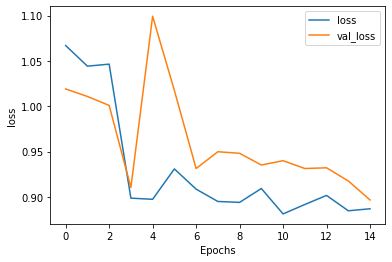

In [197]:
plot_graphs(history_RNN_w2v, 'accuracy')
plot_graphs(history_RNN_w2v, 'loss')

## Bidirectional Long short term memory network (Bi-LSTM) + Word2Vec
Contoh sebelumnya kita hanya menggunakan dictionary yang dihasilkan ketika proses Tokenizing. Lalu, ketika pemodelan ditambahkan layer embedding sebelum di fitkan ke layer LSTM.


Selanjutnya, kita akan memanfaatkan word2vec yang telah dilatih pada proses sebelumnya untuk mengubah teks menjadi bentuk vektor.





### Load Word2Vec

In [173]:
# Load word2vec yang telah kita simpan
from gensim.models import KeyedVectors

my_word2vec = KeyedVectors.load('myvec-word2vec-100.wordvectors', mmap='r')
my_word2vec_vocab = my_word2vec.wv.vocab     

VOCAB_SIZE = len(my_word2vec_vocab)
EMBEDDING_SIZE = my_word2vec.vector_size

print(VOCAB_SIZE)
print(EMBEDDING_SIZE)

4289
100


In [174]:
word2vec_dict = {}

for word in my_word2vec_vocab:
    word2vec_dict[word] = my_word2vec.wv.get_vector(word)   
    
print('The numbers of key-value pairs: ', len(word2vec_dict)) # Harus sama dengan ukuran vocab word2vec

The numbers of key-value pairs:  4289


### Create Embedding Matrix

In [175]:
EMBEDDING_MATRIX = np.zeros(shape=(WV_DICTIONARY_SIZE, EMBEDDING_SIZE))

for word, i in tokenizer.word_index.items():
  embed_vector = word2vec_dict.get(word)
  if embed_vector is not None:               # Word is in the vocabulary learned by the w2v model
    EMBEDDING_MATRIX[i] = embed_vector

In [176]:
# Cek index keberapa di Word2Vec vocabulary dari suatu kata
print(WV_DICTIONARY.get('saya'))

25


In [177]:
# Cek vector dari suatu kata
print(EMBEDDING_MATRIX[25])

[-0.69215274  0.55327111 -0.76673156 -0.06291015 -0.05846297  1.25074375
  0.65673387 -0.22346473  0.48367059 -0.01095334 -0.01288463 -1.09707677
  0.05785176 -0.01448169 -0.60100168 -0.68214363 -0.96896261  0.12979837
  0.18329942 -0.17765684  1.65343428 -0.48672336 -0.45769843  0.39509293
 -0.25665033  1.24637389 -0.6399228  -0.75150436  0.54519886  0.29564244
  0.0608554   0.3392244   0.24321972  0.94909161 -0.23341949 -0.81522787
  0.95199531 -0.02557864 -1.24681008  0.67698061 -0.33096418 -0.59250653
  0.12974732 -0.48138386  0.35994875 -0.44402984  0.63729107 -0.46249315
 -0.05876695  1.08429623  0.3288908  -0.51319361 -0.39494139 -1.10168839
  0.21054986  0.41354457  0.6291374  -0.35225254 -1.04421198  1.10438931
 -0.23921244 -0.96473449  0.53790063  0.41702813 -0.80662167  0.65853041
  0.7914061  -0.51152772 -0.74276185 -0.78842998 -0.5122298  -0.64866418
 -0.37814015  0.29869962  0.01436786 -0.71808594  0.26653689 -0.28767261
  0.31402791  0.7728827   1.49956727  1.20298254 -0

In [178]:
# Cek dimensi word vector. X = jumlah kata pada vocabulary, y = dimensi vektor
EMBEDDING_MATRIX.shape

(4287, 100)

### Define Model (Bi LSTM)
Nah, sekarang kita membahkan layer embedding berdasarkan matrix embedding yang di dapatkan dari word2vec yang sudah kita latih sebelumnya. Selain itu, kita akan mencoba menggunakan arsitektur Bidirectional LSTM.

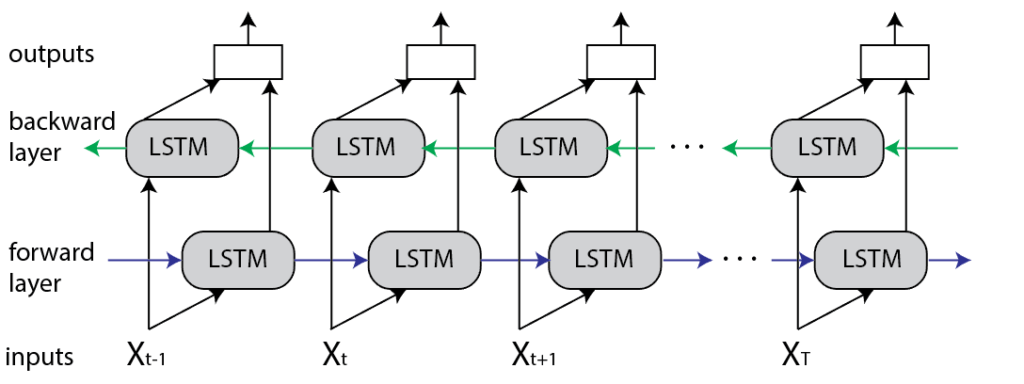



In [179]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.initializers import Constant

model_BiLSTM_w2v = Sequential()
model_BiLSTM_w2v.add(Embedding(
    input_dim = WV_DICTIONARY_SIZE,
    output_dim = EMBEDDING_SIZE,
    input_length = MAX_SEQ_LENGTH,
    trainable = False,
    embeddings_initializer = Constant(EMBEDDING_MATRIX)))
model_BiLSTM_w2v.add(Bidirectional(LSTM(64)))
# model_LSTM.add(Dropout(0.5)) 
model_BiLSTM_w2v.add(Dense(3, activation='softmax'))

In [180]:
model_BiLSTM_w2v.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 60, 100)           428700    
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 513,567
Trainable params: 84,867
Non-trainable params: 428,700
_________________________________________________________________


In [181]:
# Compile model
model_BiLSTM_w2v.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [182]:
%%time
EPOCH = 15
BATCH_SIZE = 32

history_BiLSTM_w2v = model_BiLSTM_w2v.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/15
29/29 [==============================] - 4s 39ms/step - loss: 0.7857 - accuracy: 0.7002 - val_loss: 0.5607 - val_accuracy: 0.7511
Epoch 2/15
29/29 [==============================] - 0s 10ms/step - loss: 0.4069 - accuracy: 0.8578 - val_loss: 0.3695 - val_accuracy: 0.8559
Epoch 3/15
29/29 [==============================] - 0s 10ms/step - loss: 0.3146 - accuracy: 0.8851 - val_loss: 0.3249 - val_accuracy: 0.8865
Epoch 4/15
29/29 [==============================] - 0s 11ms/step - loss: 0.2762 - accuracy: 0.9037 - val_loss: 0.3203 - val_accuracy: 0.8952
Epoch 5/15
29/29 [==============================] - 0s 10ms/step - loss: 0.2272 - accuracy: 0.9147 - val_loss: 0.3208 - val_accuracy: 0.8865
Epoch 6/15
29/29 [==============================] - 0s 10ms/step - loss: 0.1959 - accuracy: 0.9289 - val_loss: 0.3267 - val_accuracy: 0.8908
Epoch 7/15
29/29 [==============================] - 0s 10ms/step - loss: 0.1794 - accuracy: 0.9376 - val_loss: 0.3363 - val_accuracy: 0.8865
Epoch 8/15
29

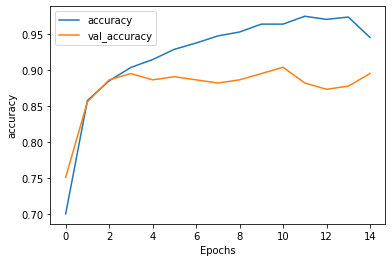

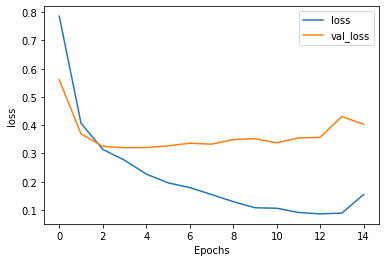

In [183]:
plot_graphs(history_BiLSTM_w2v, 'accuracy')
plot_graphs(history_BiLSTM_w2v, 'loss')

In [184]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCH):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history_BiLSTM_w2v.history['accuracy'][i], history_BiLSTM_w2v.history['loss'][i], history_BiLSTM_w2v.history['val_accuracy'][i], history_BiLSTM_w2v.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.700219 	   0.785717 	   0.751092 	   0.560669
       2   0.857768 	   0.406908 	   0.855895 	   0.369493
       3   0.885120 	   0.314554 	   0.886463 	   0.324919
       4   0.903720 	   0.276184 	   0.895196 	   0.320252
       5   0.914661 	   0.227165 	   0.886463 	   0.320832
       6   0.928884 	   0.195920 	   0.890830 	   0.326719
       7   0.937637 	   0.179368 	   0.886463 	   0.336286
       8   0.947484 	   0.154563 	   0.882096 	   0.332776
       9   0.952954 	   0.129336 	   0.886463 	   0.348957
      10   0.963895 	   0.107679 	   0.895196 	   0.352361
      11   0.963895 	   0.106018 	   0.903930 	   0.337643
      12   0.974836 	   0.091136 	   0.882096 	   0.354692
      13   0.970460 	   0.085905 	   0.873362 	   0.357192
      14   0.973742 	   0.088776 	   0.877729 	   0.430928
      15   0.945295 	   0.154799 	   0.895196 	   0.403128


In [185]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model_BiLSTM_w2v.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy = model_BiLSTM_w2v.evaluate(X_test, y_test)

8/8 [==============================] - 0s 6ms/step - loss: 0.4031 - accuracy: 0.8952


### Evaluate

#LSTM + W2V

In [144]:
# Load word2vec yang telah kita simpan
from gensim.models import KeyedVectors

my_word2vec = KeyedVectors.load('myvec-word2vec-100.wordvectors', mmap='r')
my_word2vec_vocab = my_word2vec.wv.vocab     

VOCAB_SIZE = len(my_word2vec_vocab)
EMBEDDING_SIZE = my_word2vec.vector_size

print(VOCAB_SIZE)
print(EMBEDDING_SIZE)

4289
100


In [145]:
word2vec_dict = {}

for word in my_word2vec_vocab:
    word2vec_dict[word] = my_word2vec.wv.get_vector(word)   
    
print('The numbers of key-value pairs: ', len(word2vec_dict)) # Harus sama dengan ukuran vocab word2vec

The numbers of key-value pairs:  4289


In [146]:
EMBEDDING_MATRIX = np.zeros(shape=(WV_DICTIONARY_SIZE, EMBEDDING_SIZE))

for word, i in tokenizer.word_index.items():
  embed_vector = word2vec_dict.get(word)
  if embed_vector is not None:               # Word is in the vocabulary learned by the w2v model
    EMBEDDING_MATRIX[i] = embed_vector

In [147]:
# Cek index keberapa di Word2Vec vocabulary dari suatu kata
print(WV_DICTIONARY.get('saya'))

25


In [148]:
print(EMBEDDING_MATRIX[25])

[-0.69215274  0.55327111 -0.76673156 -0.06291015 -0.05846297  1.25074375
  0.65673387 -0.22346473  0.48367059 -0.01095334 -0.01288463 -1.09707677
  0.05785176 -0.01448169 -0.60100168 -0.68214363 -0.96896261  0.12979837
  0.18329942 -0.17765684  1.65343428 -0.48672336 -0.45769843  0.39509293
 -0.25665033  1.24637389 -0.6399228  -0.75150436  0.54519886  0.29564244
  0.0608554   0.3392244   0.24321972  0.94909161 -0.23341949 -0.81522787
  0.95199531 -0.02557864 -1.24681008  0.67698061 -0.33096418 -0.59250653
  0.12974732 -0.48138386  0.35994875 -0.44402984  0.63729107 -0.46249315
 -0.05876695  1.08429623  0.3288908  -0.51319361 -0.39494139 -1.10168839
  0.21054986  0.41354457  0.6291374  -0.35225254 -1.04421198  1.10438931
 -0.23921244 -0.96473449  0.53790063  0.41702813 -0.80662167  0.65853041
  0.7914061  -0.51152772 -0.74276185 -0.78842998 -0.5122298  -0.64866418
 -0.37814015  0.29869962  0.01436786 -0.71808594  0.26653689 -0.28767261
  0.31402791  0.7728827   1.49956727  1.20298254 -0

In [149]:
# Cek dimensi word vector. X = jumlah kata pada vocabulary, y = dimensi vektor
EMBEDDING_MATRIX.shape

(4287, 100)

In [150]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

model_LSTM_w2v = Sequential()
model_LSTM_w2v.add(Embedding(
    input_dim = WV_DICTIONARY_SIZE,
    output_dim = EMBEDDING_SIZE,
    input_length = MAX_SEQ_LENGTH,
    trainable = False,
    embeddings_initializer = Constant(EMBEDDING_MATRIX))) 
model_LSTM_w2v.add(LSTM(64))                                            # Tambahkan satu layer LSTM
model_LSTM_w2v.add(Dropout(0.5))                  
model_LSTM_w2v.add(Dense(3, activation='softmax'))

model_LSTM_w2v.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 60, 100)           428700    
                                                                 
 lstm_9 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 471,135
Trainable params: 42,435
Non-trainable params: 428,700
_________________________________________________________________


In [151]:
# Compile model
model_LSTM_w2v.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [157]:
%%time
EPOCH = 15
BATCH_SIZE = 32

history_LSTM_w2v = model_LSTM_w2v.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/15
29/29 [==============================] - 0s 9ms/step - loss: 0.2590 - accuracy: 0.9125 - val_loss: 0.5187 - val_accuracy: 0.8690
Epoch 2/15
29/29 [==============================] - 0s 8ms/step - loss: 0.2595 - accuracy: 0.9070 - val_loss: 0.5385 - val_accuracy: 0.8646
Epoch 3/15
29/29 [==============================] - 0s 8ms/step - loss: 0.2355 - accuracy: 0.9158 - val_loss: 0.5367 - val_accuracy: 0.8821
Epoch 4/15
29/29 [==============================] - 0s 9ms/step - loss: 0.2398 - accuracy: 0.9256 - val_loss: 0.5100 - val_accuracy: 0.8603
Epoch 5/15
29/29 [==============================] - 0s 7ms/step - loss: 0.2349 - accuracy: 0.9223 - val_loss: 0.5339 - val_accuracy: 0.8734
Epoch 6/15
29/29 [==============================] - 0s 7ms/step - loss: 0.2348 - accuracy: 0.9158 - val_loss: 0.5470 - val_accuracy: 0.8734
Epoch 7/15
29/29 [==============================] - 0s 9ms/step - loss: 0.2291 - accuracy: 0.9158 - val_loss: 0.5618 - val_accuracy: 0.8603
Epoch 8/15
29/29 [==

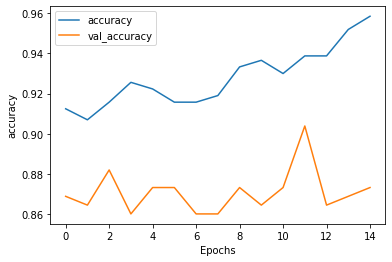

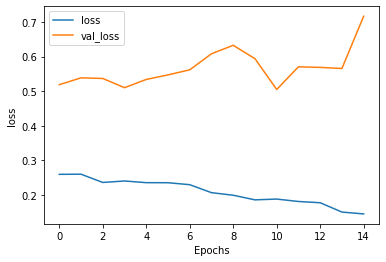

In [158]:
plot_graphs(history_LSTM_w2v, 'accuracy')
plot_graphs(history_LSTM_w2v, 'loss')

In [169]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model_LSTM_w2v.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy = model_LSTM_w2v.evaluate(X_test, y_test)

8/8 [==============================] - 0s 5ms/step - loss: 0.7169 - accuracy: 0.8734


In [160]:
# Tampilkan laporan klasifikasi yang dilakukan model pada data uji
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       112
           1       0.93      0.73      0.82        78
           2       0.80      0.92      0.86        39

    accuracy                           0.87       229
   macro avg       0.87      0.87      0.86       229
weighted avg       0.88      0.87      0.87       229



#BLSTM NOT W2V

In [163]:
NUM_WORDS = 100       # Frekuensi kemunculan kata. Hanya num_words-1 yang akan disimpan pada dictionary. Berarti kata dengan kemunculan <=num_words tidak digunakan.
OOV_TOKEN = '<unk>'   # Token khusus untuk mengganti kata yang tidak terdaftar dalam dictionary.
MAX_SEQ_LENGTH = 60

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN, lower=True, split=' ')
tokenizer.fit_on_texts(data['clean_teks'])

# Tambahkan token padding untuk menyamakan ukuran dimensi embedding layer
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

WV_DICTIONARY = tokenizer.word_index

WV_DICTIONARY_SIZE = len(WV_DICTIONARY)
print(WV_DICTIONARY_SIZE) # Lihat kata unik pada dictionary yang dihasilkan

4287


In [164]:
# Lihat dictionary hasil tokenisasi
WV_DICTIONARY

{'<unk>': 1,
 'di': 2,
 'anda': 3,
 'ke': 4,
 'ini': 5,
 'info': 6,
 'ada': 7,
 'yg': 8,
 'aku': 9,
 'mau': 10,
 'dan': 11,
 'hadiah': 12,
 'dari': 13,
 'pin': 14,
 'no': 15,
 'sms': 16,
 'klik': 17,
 'cek': 18,
 'rp': 19,
 'nama': 20,
 'aja': 21,
 'pulsa': 22,
 'paket': 23,
 'hub': 24,
 'saya': 25,
 'yang': 26,
 'ya': 27,
 'untuk': 28,
 'hari': 29,
 'promo': 30,
 'jt': 31,
 'resmi': 32,
 'atau': 33,
 'rb': 34,
 'gb': 35,
 'pemenang': 36,
 'bisa': 37,
 'selamat': 38,
 'isi': 39,
 'kalau': 40,
 'utk': 41,
 'dr': 42,
 'jam': 43,
 'dengan': 44,
 'uinfo': 45,
 'nya': 46,
 'kamu': 47,
 'tri': 48,
 'ga': 49,
 'kuota': 50,
 'gratis': 51,
 'sd': 52,
 'ketik': 53,
 'ulang': 54,
 'care': 55,
 'bonus': 56,
 'hanya': 57,
 'sudah': 58,
 'pak': 59,
 'beli': 60,
 'berlaku': 61,
 'maaf': 62,
 'dgn': 63,
 'indosat': 64,
 'juga': 65,
 'bb': 66,
 'kita': 67,
 'itu': 68,
 'kalo': 69,
 'sama': 70,
 'nanti': 71,
 'kirim': 72,
 'mobil': 73,
 'telah': 74,
 'kasih': 75,
 'yth': 76,
 'kami': 77,
 'sekarang': 78

In [165]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.initializers import Constant

model_BiLSTM = Sequential()

model_BiLSTM.add(Embedding(
    input_dim = WV_DICTIONARY_SIZE,
    input_length = MAX_SEQ_LENGTH,
    output_dim = 64))

model_BiLSTM.add(Bidirectional(LSTM(64)))
# model_BiLSTM.add(Dropout(0.5))  
model_BiLSTM.add(Dense(3, activation='softmax'))

model_BiLSTM.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 60, 64)            274368    
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 3)                 387       
                                                                 
Total params: 340,803
Trainable params: 340,803
Non-trainable params: 0
_________________________________________________________________


In [166]:
# Compile model
model_BiLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [167]:
%%time
EPOCH = 15
BATCH_SIZE = 32

history_BiLSTM = model_BiLSTM.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/15
29/29 [==============================] - 4s 38ms/step - loss: 1.0288 - accuracy: 0.4770 - val_loss: 0.8617 - val_accuracy: 0.5371
Epoch 2/15
29/29 [==============================] - 0s 11ms/step - loss: 0.8141 - accuracy: 0.6258 - val_loss: 0.7159 - val_accuracy: 0.6856
Epoch 3/15
29/29 [==============================] - 0s 10ms/step - loss: 0.6411 - accuracy: 0.7046 - val_loss: 0.5654 - val_accuracy: 0.7162
Epoch 4/15
29/29 [==============================] - 0s 10ms/step - loss: 0.5164 - accuracy: 0.7374 - val_loss: 0.5174 - val_accuracy: 0.7948
Epoch 5/15
29/29 [==============================] - 0s 11ms/step - loss: 0.4065 - accuracy: 0.8600 - val_loss: 0.4248 - val_accuracy: 0.8472
Epoch 6/15
29/29 [==============================] - 0s 10ms/step - loss: 0.3245 - accuracy: 0.8742 - val_loss: 0.3628 - val_accuracy: 0.8821
Epoch 7/15
29/29 [==============================] - 0s 11ms/step - loss: 0.2685 - accuracy: 0.9004 - val_loss: 0.3864 - val_accuracy: 0.8646
Epoch 8/15
29

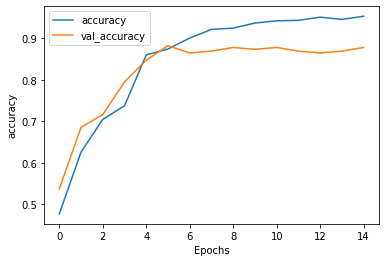

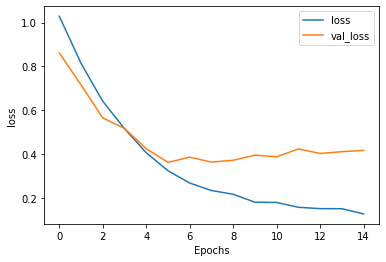

In [168]:
plot_graphs(history_BiLSTM, 'accuracy')
plot_graphs(history_BiLSTM, 'loss')

In [170]:
y_pred = np.argmax(model_BiLSTM.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy = model_BiLSTM.evaluate(X_test, y_test)
print(classification_report(y_pred, y_true))

8/8 [==============================] - 0s 6ms/step - loss: 0.4172 - accuracy: 0.8777
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       124
           1       0.79      0.87      0.83        55
           2       0.84      0.76      0.80        50

    accuracy                           0.88       229
   macro avg       0.86      0.85      0.85       229
weighted avg       0.88      0.88      0.88       229



# 07 Student Activity

Apa yang dapat Anda simpulkan dari eksperimen diatas?
1. Apakah word embedding dapat meningkatkan akurasi model? Mengapa demikian?
2. Apakah dengan menggunakan metode Bidirectional pada LSTM meningkatkan akurasi model? Mengapa demikian?

# Jawab

Apa yang dapat Anda simpulkan dari eksperimen diatas?
1. Setelah percobaan dilakukan, Word Embedding berhasil meningkatkan akurasi model yang dibuat. Metode word embedding bisa saja meningkatkan akurasi karena menutupi kekurangan yang ada pada BoW atau TFidf
2. Pada percobaan yang telah dilakukan, BLTSM berhasil menaikan akurasi model. Input pada BLSTM terdapat 2 sisi  sehingga memberikan dampak terhadap hasil yang dikeluarkan. Setiap komponen input memiliki informasi baik dari data yang lalu ataupun data yang terbaru

-----------------------------
1. LSTM: **val_accuracy: 0.7249**
2. LSTM + W2V: **val_accuracy: 0.8734**
-----------------------------
3. BiLSTM: **val_accuracy: 0.8777**
4. BiLSTM + W2V: **val_accuracy: 0.8952**